In [39]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import pyro
import torch
import pyro.optim as optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO, Predictive, MCMC, NUTS
from pyro.distributions import constraints

# Type Level Model
Here, we will model each post as coming from one of four types.

# Data

First, we load the Reddit datasets

In [40]:
comments = dict()
with open('../data/results/Comments.json') as f:
    for line in f:
        post = json.loads(line)
        comments[post['pid']] = post['api_num_comments'], post['comments']

In [41]:
corrections = []
with open('../data/results/CorrectionPairs.json') as f:
    for line in f:
        corrections.append(json.loads(line))

In [42]:
news = []
with open('../data/results/NewsPairs.json') as f:
    for line in f:
        news.append(json.loads(line))

Gather relevant variables

In [43]:
def processData(data, items, comments, minutes=60, offset=0):
    for idx, n in enumerate(items):
        i = idx + offset
        
        isNews = 'isFakeStory' in n['r']['reviewRating']
        news_id = n['p']['id']
        
        num_cmts, cmts = comments[news_id]
        c_body_lens = []
        c_ups = []
        c_downs = []
        unique_authors = set()
        for c in cmts:
            # skip if comment not created in first _ mins
            if c['delta_seconds'] > minutes * 60:
                continue

            c_minutes = c['delta_seconds'] / 60
            if c_minutes <= minutes:   # cmts in first _ mins
                data[i, 7] += 1
            
            c_body_lens.append(c['body_len'])
            c_ups.append(c['ups'])
            c_downs.append(c['downs'])
            
            if c['author']:
                unique_authors.add(c['author'])

        data[i, 0] = num_cmts
        if isNews:
            data[i, 1] = 1 if n['r']['reviewRating']['isFakeStory'] else 0
        else:
            data[i, 1] = 3 if n['r']['reviewRating']['isFakeClaim'] else 2
        data[i, 2] = np.mean(c_body_lens) if c_body_lens else 0.
        data[i, 3] = np.std(c_body_lens) if c_body_lens else 0.
        data[i, 4] = np.mean(c_ups) if c_ups else 0.
        data[i, 5] = np.std(c_ups) if c_ups else 0.
        data[i, 6] = len(unique_authors) if unique_authors else 0.
    return data

In [44]:
num_p_indep = 8
data = np.zeros((len(news) + len(corrections), num_p_indep))

data = processData(data, news, comments)
data = processData(data, corrections, comments, offset=len(news))

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

In [45]:
# select relevant indep vars
p_data = data[:, (2,4,6,7)]  # avg cmt length, avg upvotes, num authors, num initial comments
p_data = data[:,7].reshape(-1,1)  # num comments in 1st hr
p_types = data[:,1] # type of each post.
t_data = np.empty((len(np.unique(p_types)),0))

# add bias terms
p_bias = np.ones_like(p_data)
t_bias = np.ones((t_data.shape[0],1))
p_data = np.concatenate((p_bias, p_data), axis=1)
t_data = np.concatenate((t_bias, t_data), axis=1)

# get dep var
y = data[:,0].reshape(-1,1)

split into train/test

In [46]:
train_frac = 0.7
num_obs = p_data.shape[0]
idx = np.random.binomial(1, train_frac, size=num_obs).astype(bool)

p_data_train = p_data[idx,:]
p_data_test = p_data[~idx,:]

p_types_train = p_types[idx]
p_types_test = p_types[~idx]

y_train = y[idx,:]
y_test = y[~idx,:]

-----

# Modeling

Cast data to torch tensors

In [55]:
p_data_train = torch.Tensor(p_data_train)
p_data_test = torch.Tensor(p_data_test)
p_types_train = torch.Tensor(p_types_train)
p_types_test = torch.Tensor(p_types_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
t_data = torch.Tensor(t_data)

2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + eta_01 silliness_t + nu_0t

phi_1t = eta_10 * bias + eta_11 silliness_t + nu_1t

In [85]:
def model_no_subsample(p_data, p_types, t_data, y):
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    
    # define a prior for our regression variables
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps))
    alpha_scale = 10. * torch.ones((num_p_indeps, num_t_indeps))
    
    eta = pyro.sample("eta", dist.Normal(alpha_loc, alpha_scale))
    
    
    with pyro.plate("type", num_types, dim=-1) as t:
        phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)
        
        phi = pyro.sample("phi", dist.Normal(phi_loc, 10.))
    
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 100.))
        
    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", num_posts, dim=-1) as p:
        
        t = p_types[p].long()

        # indep vars for this post
        indeps = p_data[p,:]
        
        coefs = phi[:,t] # (num_p_indeps,num_posts)

        # calculate the mean: desired shape (num_posts, 1)
        mu = torch.mul(coefs, indeps.T).sum(dim=0)  # ((num_p_indeps, num_posts) .* (num_p_indeps, num_posts)).sum(over indeps)

        # sample
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y[p])


In [86]:
def model(p_data, p_types, t_data, y):
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    
    # define a prior for our regression variables
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps))
    alpha_scale = 10. * torch.ones((num_p_indeps, num_t_indeps))
    
    eta = pyro.sample("eta", dist.Normal(alpha_loc, alpha_scale))
    
    
    with pyro.plate("type", num_types, dim=-1) as t:
        phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)
        
        phi = pyro.sample("phi", dist.Normal(phi_loc, 10.))
    
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 100.))    
        
    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", num_posts, subsample_size=100, dim=-1) as p:
        
        t = p_types[p].long()

        # indep vars for this post
        indeps = p_data[p,:]
        
        coefs = phi[:,t] # (num_p_indeps,num_posts)

        # calculate the mean: desired shape (num_posts, 1)
        mu = torch.mul(coefs, indeps.T).sum(dim=0)  # ((num_p_indeps, num_posts) .* (num_p_indeps, num_posts)).sum(over indeps)

        # sample
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y[p])


In [89]:
def guide(p_data, p_types, t_data, y):
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    
    # define a prior for our regression variables
    
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps))
    alpha_scale = 10. * torch.ones((num_p_indeps, num_t_indeps))
    
    # The zeros and ones are the "alpha" in the graphical model from the proposal
    eta_loc = pyro.param("eta_loc", alpha_loc)
    eta_scale = pyro.param("eta_scale", alpha_scale, constraint=constraints.positive)
    
    eta = pyro.sample("eta", dist.Normal(eta_loc, eta_scale))
    
    phi_scale = pyro.param("phi_scale", 
                           10. * torch.ones((num_p_indeps, num_types)), 
                           constraint=constraints.positive)
    
    with pyro.plate("type", num_types, dim=-1) as t:
        phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)
        
        phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale[:,t]))
    
    sigma_loc = pyro.param('sigma_loc', torch.Tensor([1.]),
                             constraint=constraints.positive)
    sigma = pyro.sample("sigma", dist.Uniform(sigma_loc, sigma_loc * 1.1))


# Inference

## SVI

In [90]:
SUBSAMPLE = False

svi = SVI(model,
          guide,
          optim.Adam({"lr": .1}),
          loss=JitTrace_ELBO())

pyro.clear_param_store()
num_iters = 10000
losses = np.zeros((num_iters,))
for i in range(num_iters):
    if SUBSAMPLE:
        elbo = svi.step(p_data_train[:250], p_types_train[:250], t_data, y_train[:250])
    else:
        elbo = svi.step(p_data_train, p_types_train, t_data, y_train)
    losses[i] = elbo
    if i % 100 == 0:
        print("Elbo loss: {}".format(elbo))

<ipython-input-89-6f963afea8f9>:25: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  sigma_loc = pyro.param('sigma_loc', torch.Tensor([1.]),
/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/pyro/poutine/subsample_messenger.py:52: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  result = torch.randperm(self.size, device=self.device)[:subsample_size].clone()


Elbo loss: 528149504.0
Elbo loss: 19567840.0
Elbo loss: 6358732.0
Elbo loss: 7184762.0
Elbo loss: 74535824.0
Elbo loss: 7721220.0
Elbo loss: 7062009.0
Elbo loss: 7648056.5
Elbo loss: 7368047.5
Elbo loss: 9925428.0
Elbo loss: 8469991.0
Elbo loss: 81423592.0
Elbo loss: 8222138.0
Elbo loss: 8368748.0
Elbo loss: 13395792.0
Elbo loss: 9797677.0
Elbo loss: 9029248.0
Elbo loss: 9361300.0
Elbo loss: 8235091.5
Elbo loss: 8211197.5
Elbo loss: 8786704.0
Elbo loss: 11221349.0
Elbo loss: 8704622.0
Elbo loss: inf
Elbo loss: 32191064.0
Elbo loss: inf
Elbo loss: inf
Elbo loss: inf
Elbo loss: inf
Elbo loss: inf
Elbo loss: inf
Elbo loss: inf
Elbo loss: inf


KeyboardInterrupt: 

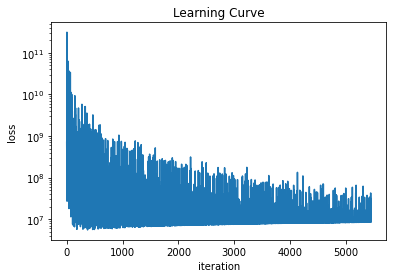

In [80]:
plt.plot(range(len(losses)), np.array(losses))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale("log")
plt.title("Learning Curve")
plt.show()

In [67]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(p_data_test, p_types_test, t_data, y_test).items()
               if k != "obs"}

## MCMC (NUTS)

In [68]:
kernel = NUTS(model_no_subsample)

num_iters = 1000
warmup_steps = 500
mcmc = MCMC(kernel, num_samples=num_iters, warmup_steps=warmup_steps)
mcmc.run(p_data_train[:250], p_types_train[:250], t_data, y_train[:250])

Warmup:   4%|▎         | 53/1500 [00:47,  5.06s/it, step size=6.95e-03, acc. prob=0.786]

KeyboardInterrupt: 

In [31]:
posterior_samples = mcmc.get_samples()

In [43]:
phi_means = posterior_samples["phi"].mean(dim=0)

In [44]:
sigma_mean = posterior_samples["sigma"].mean(dim=0)

# Evaluation

Check the fit

In [74]:
print(pyro.param('eta_loc'))

tensor([[3.0922],
        [0.1694]], requires_grad=True)


2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + nu_0t

phi_1t = eta_10 * bias + nu_1t

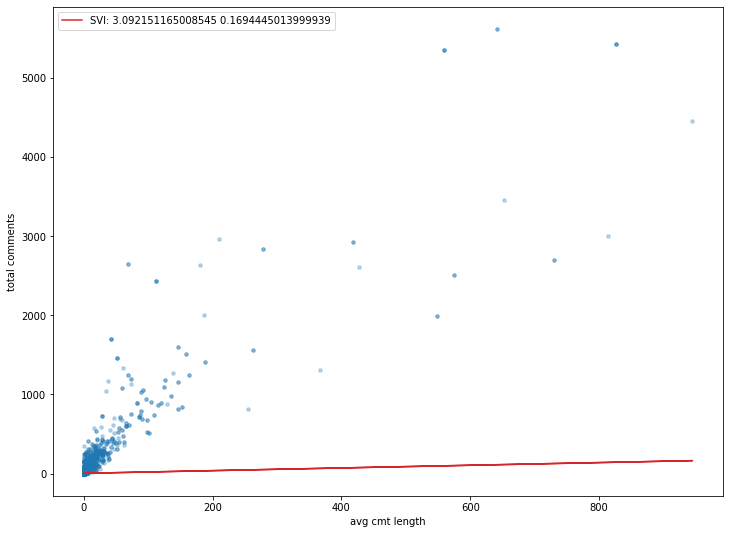

In [71]:
indep = 1

indep_dict = {
    1: "avg cmt length",
    2: "avg upvotes",
    3: "num authors",
    4: "comments in first hour",
}

phi_0_svi = float(pyro.param('eta_loc').detach().numpy()[0])
phi_1_svi = float(pyro.param('eta_loc').detach().numpy()[indep][0])

y_pred_svi = phi_0_svi
y_pred_svi += phi_1_svi * p_data[:,indep]

# y_pred_mcmc = float(phi_means[0])
# y_pred_mcmc += float(phi_means[1]) * p_data[:,indep]


plt.figure(figsize=(12,9))
plt.scatter(np.array(p_data[:,indep]), np.array(y), alpha=0.3, s=12, c='tab:blue')
plt.plot(np.array(p_data[:,indep]), np.array(y_pred_svi), c='tab:red', label=f'SVI: {phi_0_svi} {phi_1_svi}') # SVI
# plt.plot(np.array(p_data[:,indep]), np.array(y_pred_mcmc), c='tab:green', label=f'MCMC: {phi_means[0]}, {phi_means[1]}') # MCMC
plt.xlabel(indep_dict[indep])
plt.ylabel('total comments')
plt.legend()
plt.show()

Interpretation:

- For posts with no comments in the first hour, we expect 7.23 comments in total
- For every comment in the first hour, we expect an additional 6.43 comments in total

----

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/arviz/data/io_pyro.py:152: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


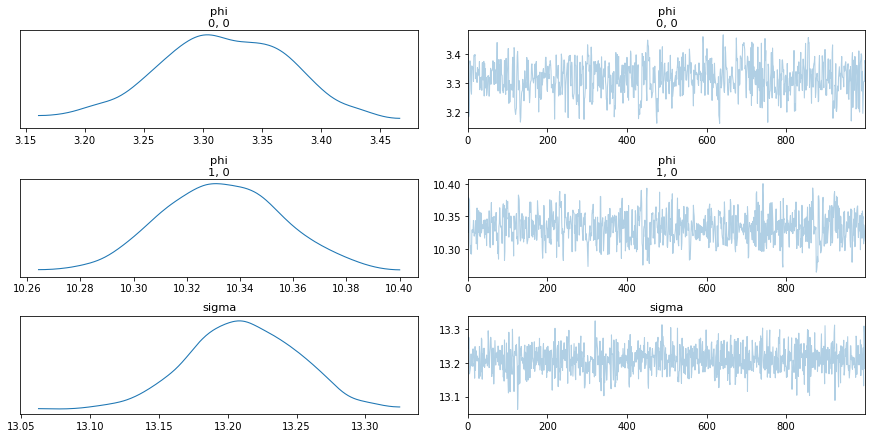

In [53]:
data = az.from_pyro(mcmc)
az.plot_trace(data, compact=False);

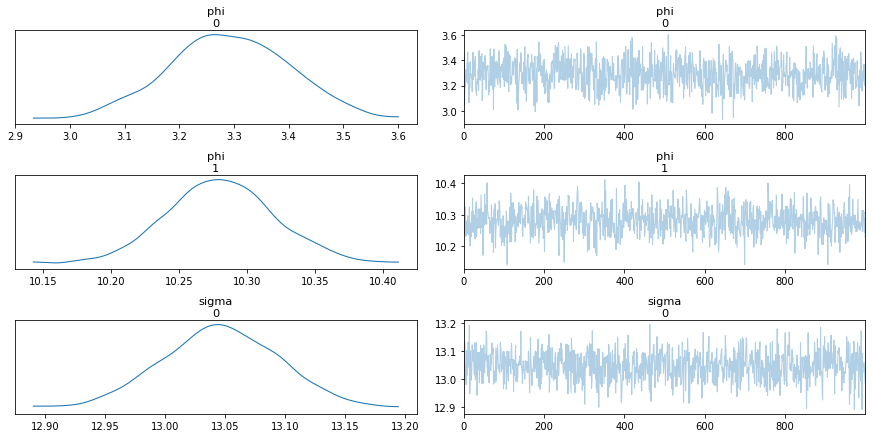

In [58]:
az_samples = az.convert_to_inference_data(svi_samples)
az.plot_trace(az_samples, compact=False);